# 🌾 Pasture Land Cover Analysis - EuroSAT Multispectral Dataset

## Overview
This notebook provides comprehensive analysis of Pasture class satellite imagery from the EuroSAT multispectral dataset. We'll explore spectral signatures, vegetation indices, and pasture characteristics using Sentinel-2 data.

## What You'll Learn:
- ✅ Dataset validation and structure exploration
- ✅ Dataset balancing to a uniform size (if needed)
- 📊 Multispectral band analysis and statistics
- 🌿 Vegetation index calculations (NDVI, EVI, SAVI)
- 🎨 RGB and false-color composite visualization
- 📈 Pasture health and density assessment
- 🔍 Comparative analysis across pasture patches

---


## 🔧 Step 1: Dataset Setup and Validation

### What this cell does:
- **📁 Path Configuration**: Sets up the correct path to your EuroSAT dataset
- **✅ Data Validation**: Checks if all folders and files exist
- **📊 Dataset Overview**: Counts files per class and displays structure
- **🛡️ Error Prevention**: Stops execution early if paths are wrong

### Key Outputs:
- Confirmation that dataset is found and accessible
- List of all land cover classes available
- File count per class for data balance assessment
- Sample pasture file names for verification


🚀 Starting Pasture Analysis at 2025-09-19 00:08:48
✅ Dataset found: T:\DEPI final Project\EuroSAT_MS
✅ Found 10 land cover classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake
✅ Pasture class folder verified: T:\DEPI final Project\EuroSAT_MS\Pasture

📊 Dataset Composition (files per class):
  ✅ AnnualCrop      : 2,000 images
  ✅ Forest          : 2,000 images
  ✅ HerbaceousVegetation : 2,000 images
  ✅ Highway         : 2,000 images
  ✅ Industrial      : 2,000 images
  ✅ Pasture         : 2,000 images
  ✅ PermanentCrop   : 2,000 images
  ✅ Residential     : 2,000 images
  ✅ River           : 2,000 images
  ✅ SeaLake         : 2,000 images

🌾 Pasture Dataset Summary:
   📁 Total pasture images: 2,000
   📄 Sample filenames:
      1. Pasture_1.tif
      2. Pasture_10.tif
      3. Pasture_100.tif
      4. Pasture_1000.tif
      5. Pasture_1001.tif
      ... and 1995 more


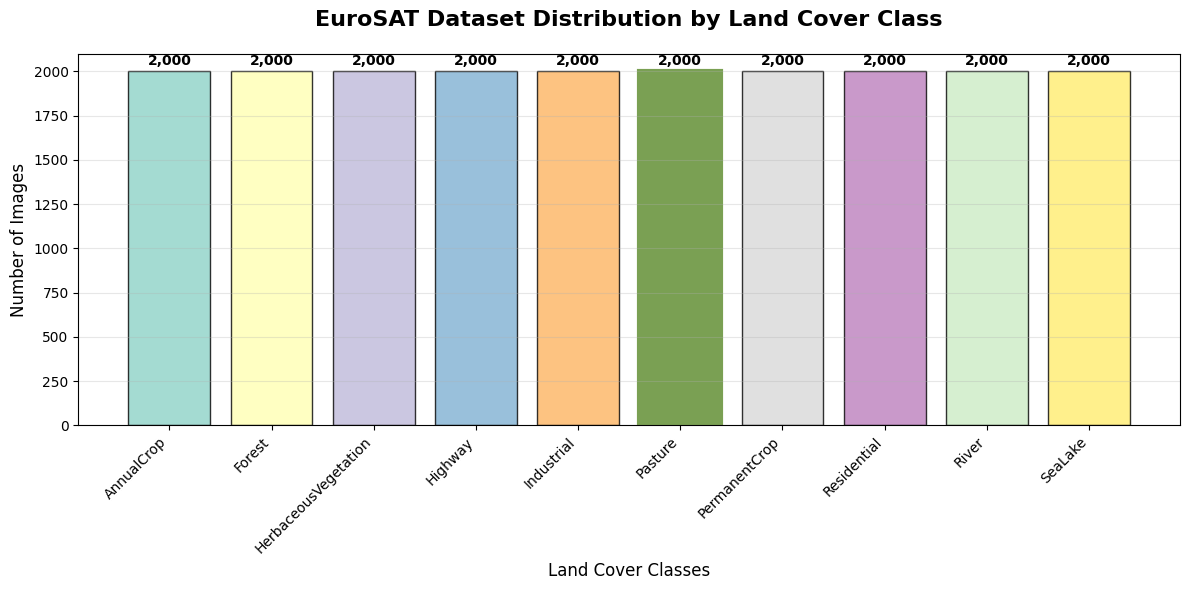


✨ Setup completed successfully! Ready to analyze 2,000 Pasture images.


In [3]:
# ====== STEP 1: Dataset Setup and Validation ======
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set a consistent style for visualizations
plt.style.use('default')
sns.set_palette("husl")

# --- Path and Class Configuration ---
# IMPORTANT: Update DATA_DIR with the correct path to your EuroSAT_MS folder
DATA_DIR = Path(r"T:\DEPI final Project\EuroSAT_MS")
CLASS_NAME = "Pasture"

print(f"🚀 Starting Pasture Analysis at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

# --- Dataset Validation ---
if not DATA_DIR.exists():
    raise FileNotFoundError(f"❌ ERROR: Dataset folder not found at: {DATA_DIR}\n"
                        f"Please update DATA_DIR with the correct path to your EuroSAT_MS folder.")
print(f"✅ Dataset found: {DATA_DIR}")

classes = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
if len(classes) == 0:
    raise FileNotFoundError(f"❌ ERROR: No class folders found inside: {DATA_DIR}\n"
                        f"Expected folders like 'Pasture', 'River', etc.")
print(f"✅ Found {len(classes)} land cover classes: {', '.join(classes)}")

pasture_dir = DATA_DIR / CLASS_NAME
if not pasture_dir.exists():
    raise FileNotFoundError(f"❌ ERROR: '{CLASS_NAME}' folder not found at: {pasture_dir}")
print(f"✅ Pasture class folder verified: {pasture_dir}")

# --- Dataset Overview ---
print("\n📊 Dataset Composition (files per class):")
counts = {}
for c in classes:
    count = len(list((DATA_DIR / c).glob("*.tif")))
    counts[c] = count
    status = "✅" if count > 0 else "⚠️"
    print(f"  {status} {c:<15} : {count:,} images")

pasture_tifs = sorted(pasture_dir.glob("*.tif"))
if len(pasture_tifs) == 0:
    raise FileNotFoundError(f"❌ ERROR: No .tif files found in {pasture_dir}")
print(f"\n🌾 Pasture Dataset Summary:")
print(f"   📁 Total pasture images: {len(pasture_tifs):,}")
print(f"   📄 Sample filenames:")
for i, p in enumerate(pasture_tifs[:5]):
    print(f"      {i+1}. {p.name}")
if len(pasture_tifs) > 5:
    print(f"      ... and {len(pasture_tifs)-5} more")

# --- Visualize Dataset Distribution ---
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
classes_sorted = sorted(counts.keys(), key=lambda x: counts[x], reverse=True)
values = [counts[c] for c in classes_sorted]
colors = plt.cm.Set3(np.linspace(0, 1, len(classes_sorted)))

bars = plt.bar(classes_sorted, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
plt.title('EuroSAT Dataset Distribution by Land Cover Class', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Land Cover Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Highlight the bar for the current class
if 'Pasture' in classes_sorted:
    pasture_idx = classes_sorted.index('Pasture')
    bars[pasture_idx].set_color('#7AA053')  # A green/pasture-themed color
    bars[pasture_idx].set_alpha(1.0)
    bars[pasture_idx].set_linewidth(3)

plt.tight_layout()
plt.show()

print(f"\n✨ Setup completed successfully! Ready to analyze {len(pasture_tifs):,} Pasture images.")
print("=" * 60)


## ⚖️ Step 2: Balance Dataset Image Count


In [4]:
# ====== STEP 2: Balance Dataset Image Count =====
import random
import os

print("🔄 Starting dataset balancing...")
print("=" * 50)

# Set the target number of images per class
TARGET_COUNT = 2000

# Iterate over all class directories to ensure uniform size
for class_name in classes:
    class_dir = DATA_DIR / class_name
    files = sorted(list(class_dir.glob("*.tif")))
    current_count = len(files)

    if current_count > TARGET_COUNT:
        print(f"🗑️ {class_name}: Found {current_count:,} images, targeting {TARGET_COUNT:,}.")
        
        # Randomly select files to delete
        num_to_delete = current_count - TARGET_COUNT
        files_to_delete = random.sample(files, num_to_delete)
        
        # Delete the selected files
        for f in files_to_delete:
            os.remove(f)
        
        print(f"   ✅ Deleted {num_to_delete:,} images. New count: {len(list(class_dir.glob('*.tif'))):,}.")
    else:
        print(f"👍 {class_name}: Image count {current_count:,} is already at or below target.")

print("\n✨ Dataset balancing complete!")
print("=" * 50)


🔄 Starting dataset balancing...
👍 AnnualCrop: Image count 2,000 is already at or below target.
👍 Forest: Image count 2,000 is already at or below target.
👍 HerbaceousVegetation: Image count 2,000 is already at or below target.
👍 Highway: Image count 2,000 is already at or below target.
👍 Industrial: Image count 2,000 is already at or below target.
👍 Pasture: Image count 2,000 is already at or below target.
👍 PermanentCrop: Image count 2,000 is already at or below target.
👍 Residential: Image count 2,000 is already at or below target.
👍 River: Image count 2,000 is already at or below target.
👍 SeaLake: Image count 2,000 is already at or below target.

✨ Dataset balancing complete!


## 🔬 Step 3: Deep Dive into Multispectral Pasture Imagery


🔍 Analyzing sample: Pasture_1.tif
📏 Spatial Dimensions: 64 × 64 pixels
📊 Spectral Bands: 13 bands
🗂️ Data Type: uint16
🌍 Coordinate System: EPSG:32632
📐 Pixel Size: 10.0m × 10.0m
📍 Geographic Bounds:
   West: 546010.253207, East: 546649.310424
   North: 5583837.761680, South: 5583198.797043

📈 Detailed Band Statistics:
Band   Name         Wavelength Min      Mean     Max      Std      Non-Zero% 
---------------------------------------------------------------------------
B01    Coastal Aerosol 443nm      1158     1229     1327     40.1     100.0     
B02    Blue         490nm      774      953      1177     78.2     100.0     
B03    Green        560nm      550      872      1125     115.1    100.0     
B04    Red          665nm      327      662      1238     206.8    100.0     
B05    Red Edge 1   705nm      500      1027     1420     184.3    100.0     
B06    Red Edge 2   740nm      1219     2314     3723     414.7    100.0     
B07    Red Edge 3   783nm      1574     2881     4825 

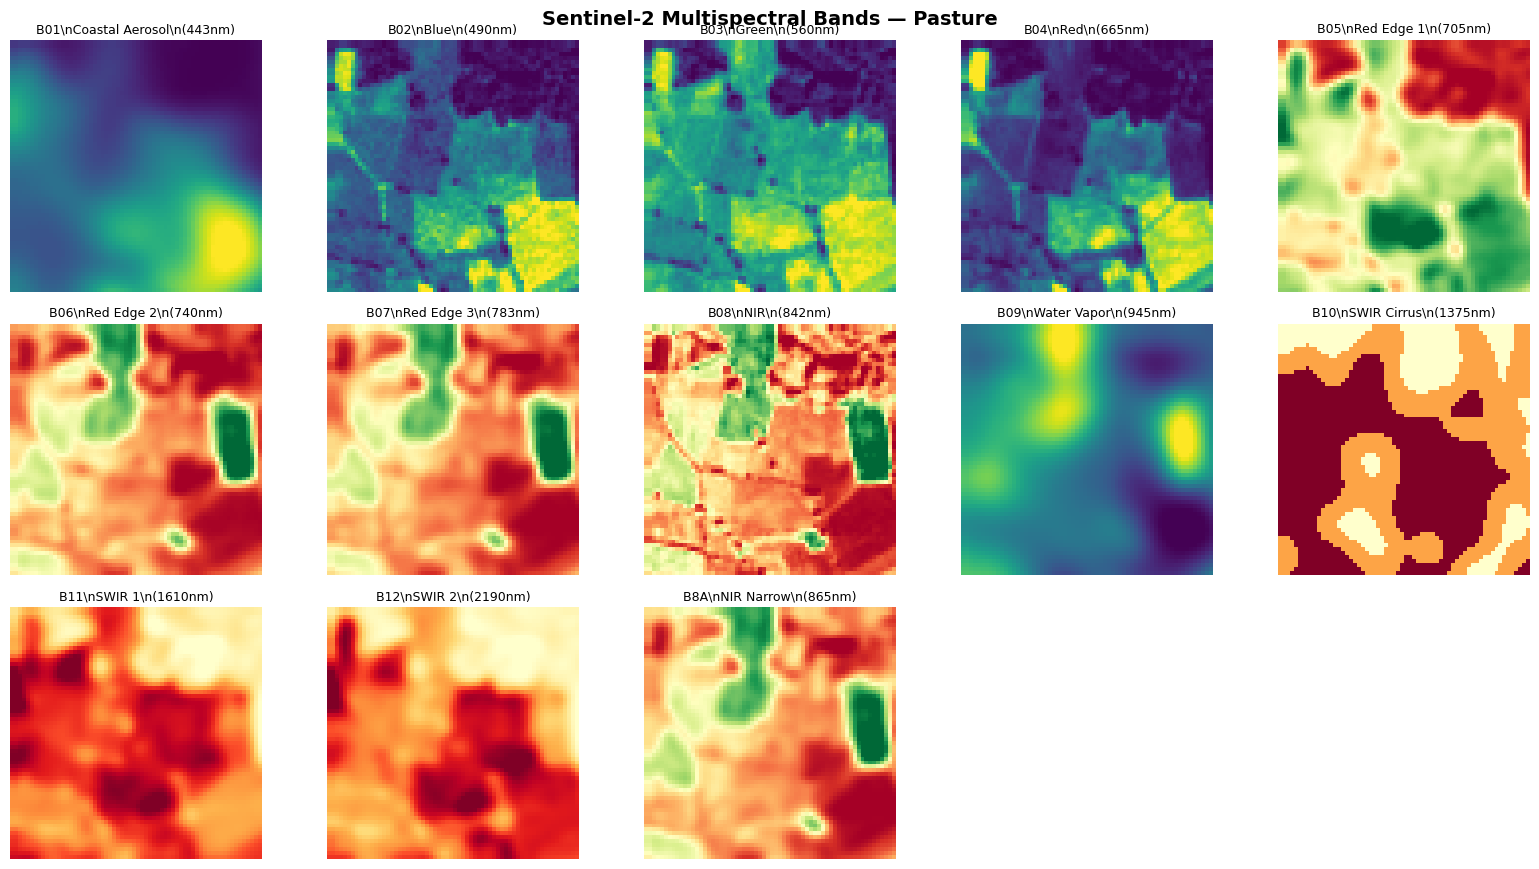


🌈 Creating RGB True Color Composite...


C:\Users\tadoa\AppData\Local\Temp\ipykernel_2820\814778239.py:103: UserWarning: Glyph 127806 (\N{EAR OF RICE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
c:\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127806 (\N{EAR OF RICE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


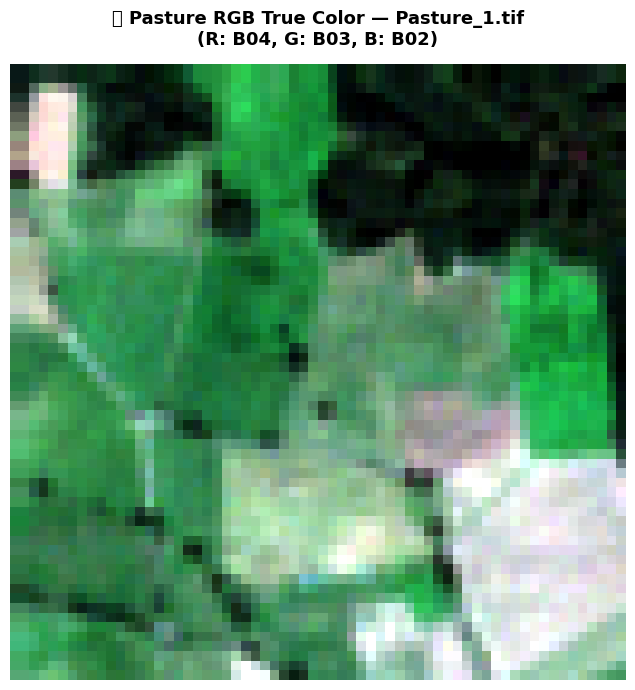


🌿 Computing Advanced Vegetation Indices...


C:\Users\tadoa\AppData\Local\Temp\ipykernel_2820\814778239.py:128: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
c:\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


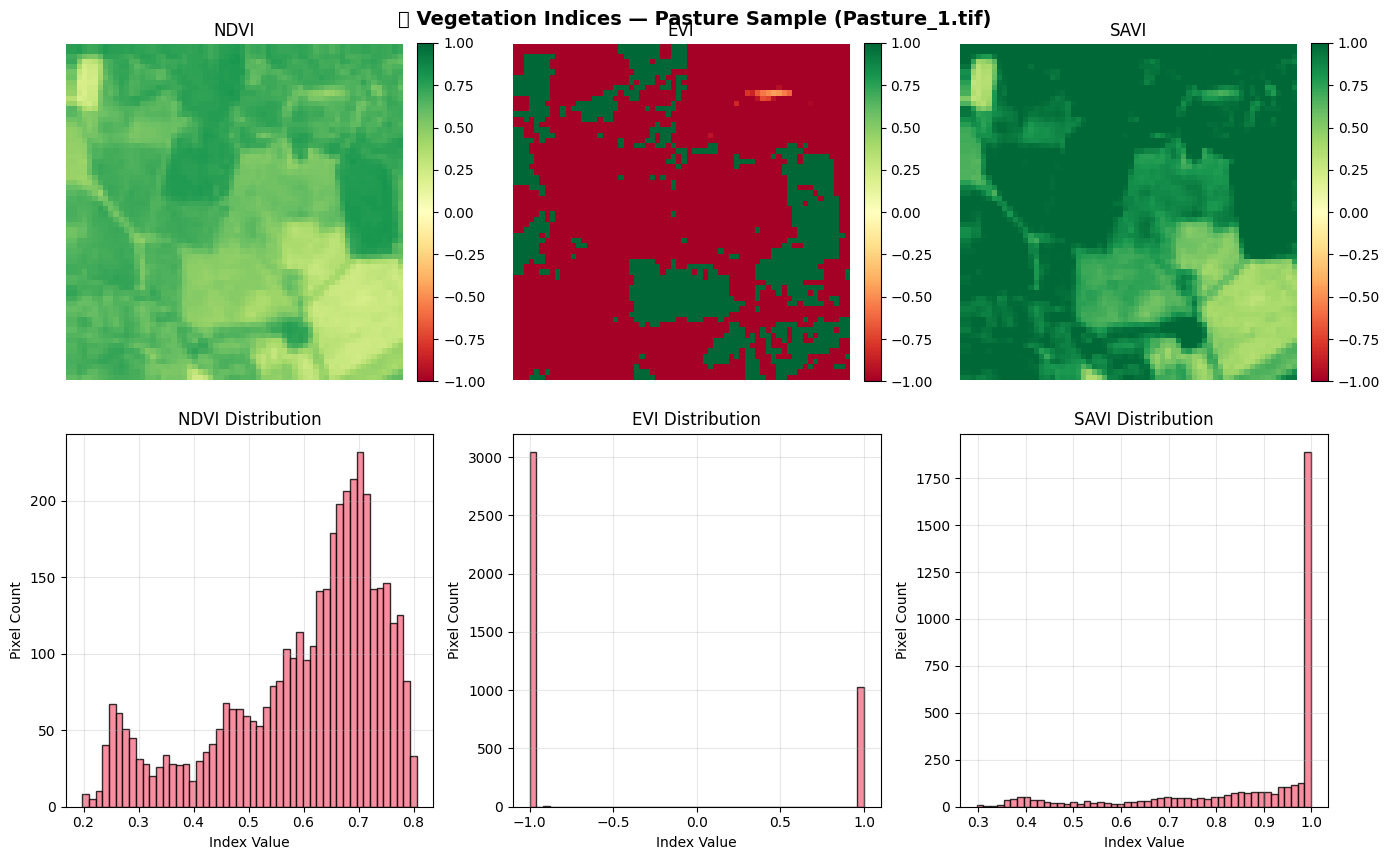


🏥 Pasture Health Assessment:
----------------------------------------
🌾 Very Healthy (NDVI > 0.6): 61.1%
🌱 Healthy (0.3–0.6):        31.6%
🍂 Moderate (0.1–0.3):       7.3%
🪴 Sparse (-0.1–0.1):        0.0%
🏔️ Non-Vegetation (< -0.1):  0.0%

🎯 Overall Health Score: 0.900 → Excellent 🌾✨
✅ Deep multispectral analysis completed!


In [5]:
# ====== STEP 3: Deep Multispectral Analysis of Single Pasture Image ======
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Get the list of images for the Pasture class after balancing
sample_paths = sorted((DATA_DIR / CLASS_NAME).glob("*.tif"))
sample = sample_paths[0]
print(f"🔍 Analyzing sample: {sample.name}")
print("=" * 50)

# --- Read and display metadata ---
with rasterio.open(sample) as src:
    band_count = src.count
    height, width = src.height, src.width
    crs = src.crs
    transform = src.transform
    dtype = src.dtypes[0]
    bounds = src.bounds
    
    print(f"📏 Spatial Dimensions: {height} × {width} pixels")
    print(f"📊 Spectral Bands: {band_count} bands")
    print(f"🗂️ Data Type: {dtype}")
    print(f"🌍 Coordinate System: {crs}")
    print(f"📐 Pixel Size: {abs(transform[0]):.1f}m × {abs(transform[4]):.1f}m")
    print(f"📍 Geographic Bounds:")
    print(f"   West: {bounds.left:.6f}, East: {bounds.right:.6f}")
    print(f"   North: {bounds.top:.6f}, South: {bounds.bottom:.6f}")

# --- Define Sentinel-2 band metadata ---
SENTINEL2_BANDS = {
    1: ('B01', 'Coastal Aerosol', '443nm', 60), 2: ('B02', 'Blue', '490nm', 10),
    3: ('B03', 'Green', '560nm', 10), 4: ('B04', 'Red', '665nm', 10),
    5: ('B05', 'Red Edge 1', '705nm', 20), 6: ('B06', 'Red Edge 2', '740nm', 20),
    7: ('B07', 'Red Edge 3', '783nm', 20), 8: ('B08', 'NIR', '842nm', 10),
    9: ('B09', 'Water Vapor', '945nm', 60), 10: ('B10', 'SWIR Cirrus', '1375nm', 60),
    11: ('B11', 'SWIR 1', '1610nm', 20), 12: ('B12', 'SWIR 2', '2190nm', 20),
    13: ('B8A', 'NIR Narrow', '865nm', 20)
}

# --- Function to apply contrast stretch to improve visualization ---
def enhanced_stretch(x, percentiles=(2, 98), gamma=1.0):
    x = x.astype(np.float32)
    valid = x[x > 0]
    if valid.size == 0:
        valid = x
    lo, hi = np.percentile(valid, percentiles)
    stretched = np.clip((x - lo) / (hi - lo + 1e-6), 0, 1)
    return np.power(stretched, 1/gamma)

# --- Read all bands from the sample image ---
with rasterio.open(sample) as src:
    all_bands = [src.read(b).astype(np.float32) for b in range(1, band_count+1)]

print("\n📈 Detailed Band Statistics:")
print(f"{'Band':<6} {'Name':<12} {'Wavelength':<10} {'Min':<8} {'Mean':<8} {'Max':<8} {'Std':<8} {'Non-Zero%':<10}")
print("-" * 75)

band_stats = []
for i, arr in enumerate(all_bands, start=1):
    band_info = SENTINEL2_BANDS.get(i, (f'B{i:02d}', 'Unknown', 'N/A', 'N/A'))
    non_zero_pct = (np.count_nonzero(arr) / arr.size) * 100
    stats = {'band': band_info[0],'name': band_info[1],'wavelength': band_info[2],'resolution': band_info[3],
             'min': float(arr.min()),'mean': float(arr.mean()),'max': float(arr.max()),'std': float(arr.std()),'non_zero_pct': non_zero_pct}
    band_stats.append(stats)
    print(f"{band_info[0]:<6} {band_info[1]:<12} {band_info[2]:<10} {arr.min():<8.0f} {arr.mean():<8.0f} {arr.max():<8.0f} {arr.std():<8.1f} {non_zero_pct:<10.1f}")

# --- Visualize all 13 bands ---
fig = plt.figure(figsize=(16, 9))
cols, rows = 5, 3
for i, stats in enumerate(band_stats[:13], start=1):
    arr = all_bands[i-1]
    ax = fig.add_subplot(rows, cols, i)
    # Use specific colormaps for different band types for better contrast
    if 'NIR' in stats['name'] or 'Red Edge' in stats['name']:
        cmap = 'RdYlGn'
    elif 'SWIR' in stats['name']:
        cmap = 'YlOrRd'
    else:
        cmap = 'viridis'
    im = ax.imshow(enhanced_stretch(arr, gamma=0.8), cmap=cmap)
    ax.set_title(f"{stats['band']}\\n{stats['name']}\\n({stats['wavelength']})", fontsize=9, pad=5)
    ax.axis('off')
plt.suptitle(f"Sentinel-2 Multispectral Bands — {CLASS_NAME}", fontsize=14, fontweight='bold', y=0.96)
plt.tight_layout(); plt.show()

print("\n🌈 Creating RGB True Color Composite...")
with rasterio.open(sample) as src:
    red   = src.read(4).astype(np.float32)
    green = src.read(3).astype(np.float32)
    blue  = src.read(2).astype(np.float32)

# --- Stack and stretch bands for a true color image ---
rgb = np.dstack([
    enhanced_stretch(red,   percentiles=(1, 99), gamma=0.8),
    enhanced_stretch(green, percentiles=(1, 99), gamma=0.8),
    enhanced_stretch(blue,  percentiles=(1, 99), gamma=0.8)
])

plt.figure(figsize=(8, 7))
plt.imshow(rgb); plt.axis('off')
plt.title(f"🌾 Pasture RGB True Color — {sample.name}\n(R: B04, G: B03, B: B02)", fontsize=13, fontweight='bold', pad=14)
plt.tight_layout(); plt.show()

print("\n🌿 Computing Advanced Vegetation Indices...")
with rasterio.open(sample) as src:
    nir  = src.read(8).astype(np.float32)
    red  = src.read(4).astype(np.float32)
    blue = src.read(2).astype(np.float32)

# --- Calculate common vegetation indices ---
ndvi = (nir - red) / (nir + red + 1e-6); ndvi = np.clip(ndvi, -1, 1)
evi  = 2.5 * ((nir - red) / (nir + 6*red - 7.5*blue + 1)); evi = np.clip(evi, -1, 1)
L = 0.5
savi = ((nir - red) / (nir + red + L)) * (1 + L); savi = np.clip(savi, -1, 1)

# --- Visualize the vegetation indices and their distributions ---
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
im1 = axes[0,0].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1); axes[0,0].set_title('NDVI'); axes[0,0].axis('off'); plt.colorbar(im1, ax=axes[0,0], fraction=0.046, pad=0.04)
im2 = axes[0,1].imshow(evi,  cmap='RdYlGn', vmin=-1, vmax=1); axes[0,1].set_title('EVI');  axes[0,1].axis('off'); plt.colorbar(im2, ax=axes[0,1], fraction=0.046, pad=0.04)
im3 = axes[0,2].imshow(savi, cmap='RdYlGn', vmin=-1, vmax=1); axes[0,2].set_title('SAVI'); axes[0,2].axis('off'); plt.colorbar(im3, ax=axes[0,2], fraction=0.046, pad=0.04)

for i, (arr, title) in enumerate(zip([ndvi, evi, savi], ['NDVI Distribution','EVI Distribution','SAVI Distribution'])):
    axes[1,i].hist(arr.ravel(), bins=50, alpha=0.8, edgecolor='black')
    axes[1,i].set_title(title); axes[1,i].set_xlabel('Index Value'); axes[1,i].set_ylabel('Pixel Count'); axes[1,i].grid(True, alpha=0.3)

plt.suptitle(f"🌿 Vegetation Indices — Pasture Sample ({sample.name})", fontsize=14, fontweight='bold', y=0.95)
plt.tight_layout(); plt.show()

# --- Assess pasture health based on NDVI values ---
very_healthy = np.sum(ndvi > 0.6) / ndvi.size * 100
healthy      = np.sum((ndvi > 0.3) & (ndvi <= 0.6)) / ndvi.size * 100
moderate     = np.sum((ndvi > 0.1) & (ndvi <= 0.3)) / ndvi.size * 100
sparse       = np.sum((ndvi > -0.1) & (ndvi <= 0.1)) / ndvi.size * 100
non_veg      = np.sum(ndvi <= -0.1) / ndvi.size * 100

print("\n🏥 Pasture Health Assessment:")
print("-" * 40)
print(f"🌾 Very Healthy (NDVI > 0.6): {very_healthy:.1f}%")
print(f"🌱 Healthy (0.3–0.6):        {healthy:.1f}%")
print(f"🍂 Moderate (0.1–0.3):       {moderate:.1f}%")
print(f"🪴 Sparse (-0.1–0.1):        {sparse:.1f}%")
print(f"🏔️ Non-Vegetation (< -0.1):  {non_veg:.1f}%")

score = (very_healthy*1.0 + healthy*0.8 + moderate*0.5 + sparse*0.2)/100
status = "Excellent 🌾✨" if score>0.8 else ("Good 🌱" if score>0.6 else ("Moderate 🍂" if score>0.4 else "Poor 🪴"))
print(f"\n🎯 Overall Health Score: {score:.3f} → {status}")
print("✅ Deep multispectral analysis completed!")
print("=" * 50)


## 🔄 Step 4: Comparative Analysis Across Pasture Patches


🔄 Comparing multiple Pasture patches (RGB + NDVI + Histogram)...


C:\Users\tadoa\AppData\Local\Temp\ipykernel_2820\245877156.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


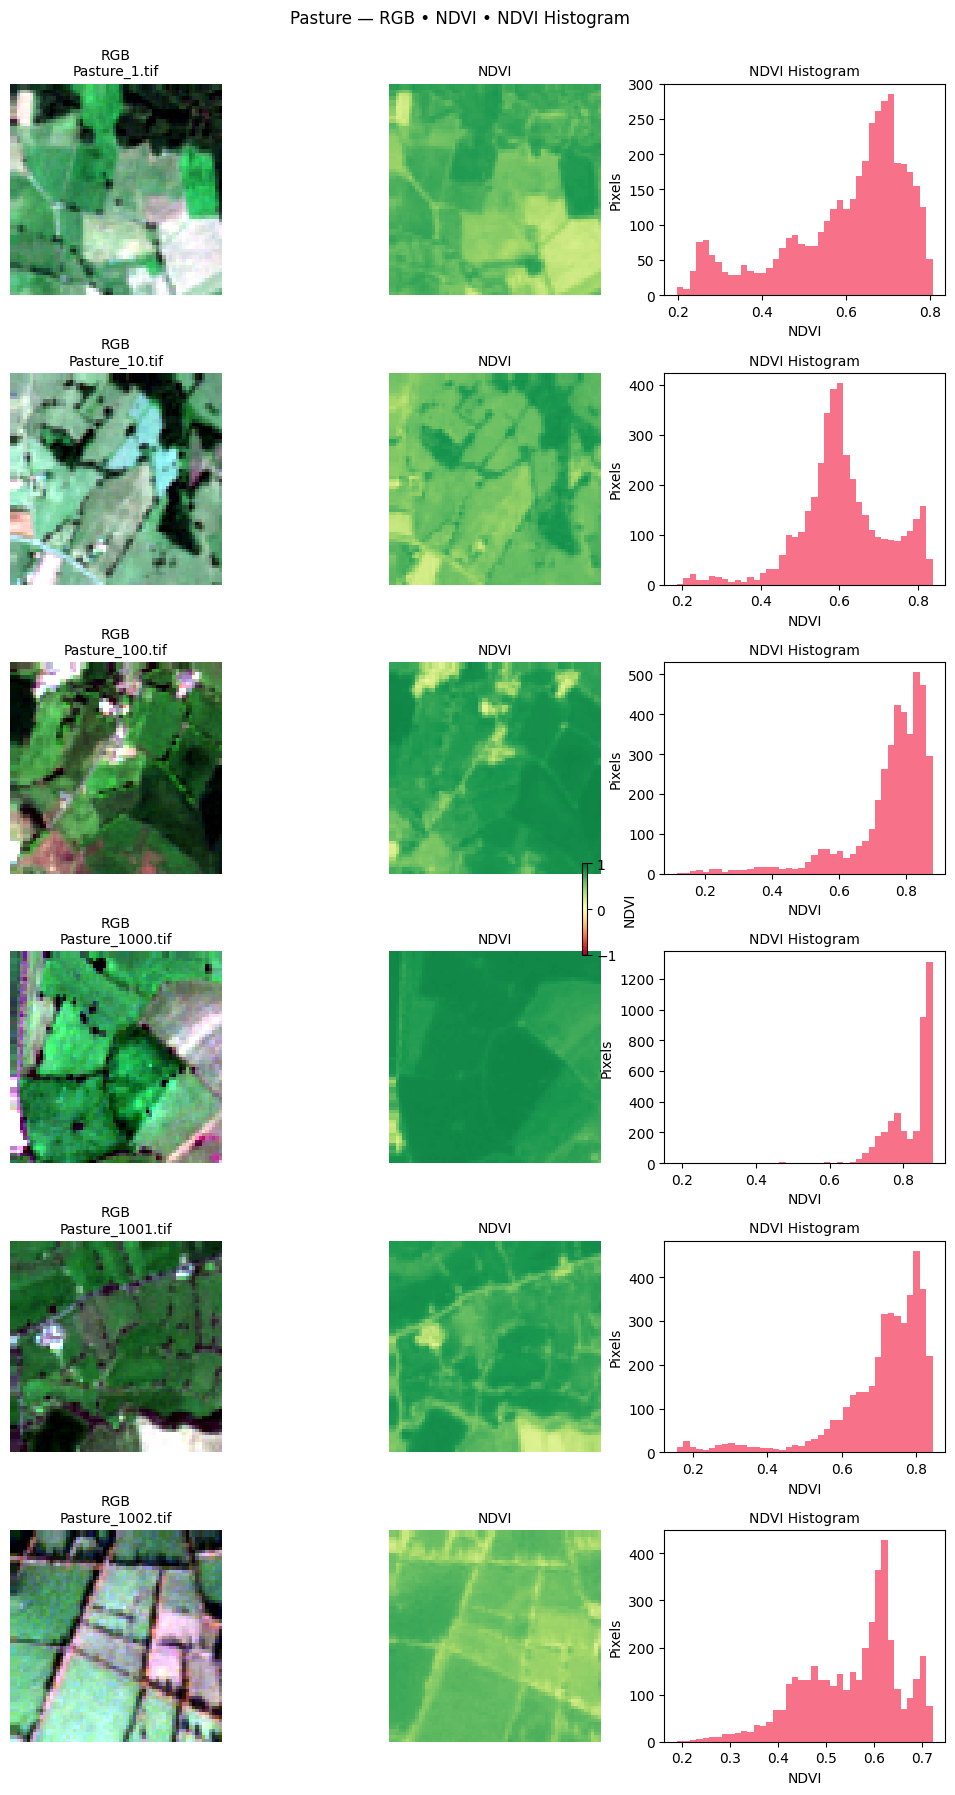

✅ Step 4 done.


In [6]:
# ====== STEP 4: Side-by-Side RGB • NDVI • NDVI Histograms (Pasture) ======
import numpy as np
import matplotlib.pyplot as plt
import rasterio

print(f"🔄 Comparing multiple {CLASS_NAME} patches (RGB + NDVI + Histogram)...")
pasture_dir = DATA_DIR / CLASS_NAME
files = sorted(pasture_dir.glob("*.tif"))
assert len(files) > 0, f"No .tif files found in {pasture_dir}"

# --- Function to apply contrast stretch for better visualization ---
def stretch01(x, p=(2, 98)):
    x = x.astype("float32")
    nonzero = x[x > 0]
    lo, hi = np.percentile(nonzero if nonzero.size else x, p)
    return np.clip((x - lo) / (hi - lo + 1e-6), 0, 1)

# --- Function to read specific bands from a .tif file ---
def read_bands(path, idxs):
    with rasterio.open(path) as src:
        return [src.read(i).astype("float32") for i in idxs]

# --- Select a subset of images for comparison ---
N = min(6, len(files))
subset = files[:N]

# --- Create a grid of subplots ---
fig, axes = plt.subplots(N, 3, figsize=(10, 3*N))
if N == 1:
    axes = np.array([axes])

last_im = None
for i, p in enumerate(subset):
    # --- RGB True Color Composite ---
    r, g, b = read_bands(p, [4, 3, 2])
    rgb = np.dstack([stretch01(r), stretch01(g), stretch01(b)])
    axes[i, 0].imshow(rgb); axes[i, 0].axis("off")
    axes[i, 0].set_title(f"RGB\n{p.name}", fontsize=10)

    # --- NDVI Image ---
    nir, red = read_bands(p, [8, 4])
    ndvi = (nir - red) / (nir + red + 1e-6); ndvi = np.clip(ndvi, -1, 1)
    last_im = axes[i, 1].imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
    axes[i, 1].set_title("NDVI", fontsize=10); axes[i, 1].axis("off")

    # --- NDVI Histogram ---
    axes[i, 2].hist(ndvi.ravel(), bins=40)
    axes[i, 2].set_title("NDVI Histogram", fontsize=10)
    axes[i, 2].set_xlabel("NDVI"); axes[i, 2].set_ylabel("Pixels")

# Add a color bar for the NDVI plots
if last_im is not None:
    cbar = plt.colorbar(last_im, ax=axes[:, 1], fraction=0.02)
    cbar.set_label("NDVI")

plt.suptitle(f"{CLASS_NAME} — RGB • NDVI • NDVI Histogram", y=0.995)
plt.tight_layout(); plt.show()
print("✅ Step 4 done.")


## 📊 Step 5: Large-Scale Pasture Spectral Statistics


📊 Starting Large-Scale Pasture Spectral Analysis...
📁 Analyzing 1,000 Pasture images out of 2,000 available
⚡ Using 4 threads for parallel processing
📏 Image dimensions: 64 × 64 pixels
📊 Spectral bands: 13
  → Processed 100/1000 images...
  → Processed 200/1000 images...
  → Processed 300/1000 images...
  → Processed 400/1000 images...
  → Processed 500/1000 images...
  → Processed 600/1000 images...
  → Processed 700/1000 images...
  → Processed 800/1000 images...
  → Processed 900/1000 images...
  → Processed 1000/1000 images...
⏱️ Finished in 23.6s | Success: 1000 | Errors: 0


,filename,band_1_mean,band_1_std,band_1_min,band_1_max,band_1_median,band_1_p05,band_1_p95,band_1_nonzero_pct,band_2_mean,...,band_12_nonzero_pct,band_13_mean,band_13_std,band_13_min,band_13_max,band_13_median,band_13_p05,band_13_p95,band_13_nonzero_pct,ndvi_mean
0,Pasture_1000.tif,1145.757324,16.426689,1121.0,1236.0,1141.0,1128.0,1176.0,100.0,861.623291,...,100.0,5463.487305,848.759033,3027.0,6678.0,5737.0,4074.50,6447.00,100.0,0.817836
1,Pasture_100.tif,1120.391357,47.470554,1057.0,1441.0,1111.0,1071.0,1200.0,100.0,872.148682,...,100.0,4405.774414,785.232300,1988.0,5775.0,4487.0,3032.75,5492.25,100.0,0.747678
2,Pasture_1.tif,1228.697266,40.148178,1158.0,1327.0,1226.0,1164.0,1305.0,100.0,953.404541,...,100.0,3251.731689,622.208130,1783.0,5247.0,3166.0,2223.25,4455.00,100.0,0.599570
3,Pasture_10.tif,1135.763916,33.894867,1050.0,1207.0,1139.0,1072.0,1185.0,100.0,927.041260,...,100.0,3641.764648,326.991791,2408.0,4601.0,3662.5,3099.00,4179.25,100.0,0.609237
4,Pasture_1002.tif,1834.253662,17.994205,1795.0,1872.0,1837.0,1807.0,1862.0,100.0,1380.073486,...,100.0,3473.680176,846.915344,1131.0,5455.0,3413.0,2108.75,4821.25,100.0,0.554109


,band,name,wavelength,resolution,mean_of_means,std_of_means,p05_mean,p95_mean,mean_of_stds,mean_p05,mean_p95,avg_nonzero_pct,n_images
0,B01,B01-Coastal,443nm,60,1308.075307,273.718499,1091.258362,1865.408154,26.971550,1274.44775,1359.16875,100.0,1000
1,B02,B02-Blue,490nm,10,1017.913229,208.149546,838.469897,1443.908191,66.804147,936.20475,1130.14325,100.0,1000
2,B03,B03-Green,560nm,10,951.838932,111.000851,820.337000,1182.481543,95.244916,797.27100,1097.97800,100.0,1000
3,B04,B04-Red,665nm,10,662.120195,142.889382,475.501160,902.705969,151.738538,481.14525,943.69775,100.0,1000
4,B05,B05-RedEdge1,705nm,20,1178.100405,124.330715,1010.942896,1400.199243,152.993831,930.00350,1430.46425,100.0,1000
5,B06,B06-RedEdge2,740nm,20,2796.978837,411.705428,2084.683508,3467.053247,421.282234,2080.22025,3444.28475,100.0,1000
6,B07,B07-RedEdge3,783nm,20,3448.299810,603.844973,2444.381555,4425.288599,573.568499,2493.43375,4355.25525,100.0,1000
7,B08,B08-NIR,842nm,10,3392.110422,579.399123,2424.512878,4321.141748,649.976261,2273.81650,4372.11425,100.0,1000
8,B09,B09-WaterVapor,945nm,60,1105.830508,336.203422,672.377917,1765.235425,121.392225,898.07550,1292.40350,100.0,1000
9,B10,B10-Cirrus,1375nm,60,13.012398,5.453394,9.177698,17.434705,1.243143,11.05350,15.02075,100.0,1000


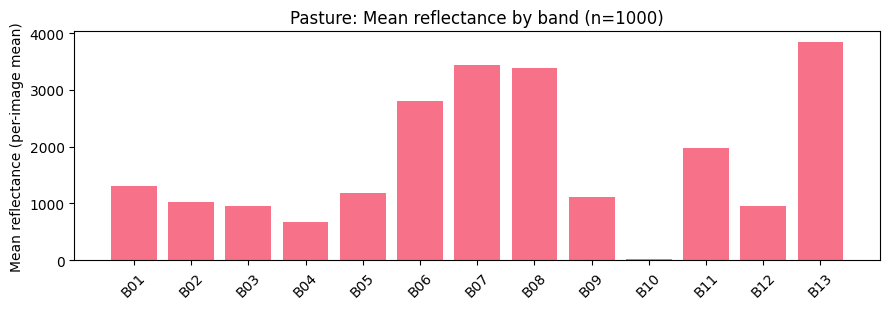

C:\Users\tadoa\AppData\Local\Temp\ipykernel_2820\2916867506.py:130: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(figsize=(10, 3.6)); plt.boxplot(data_for_box, labels=[f'B{b:02d}' for b in range(1, band_count+1)], showfliers=False)


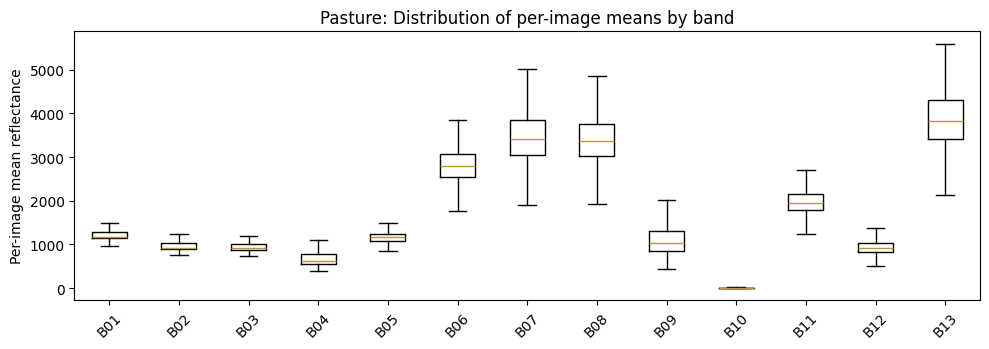

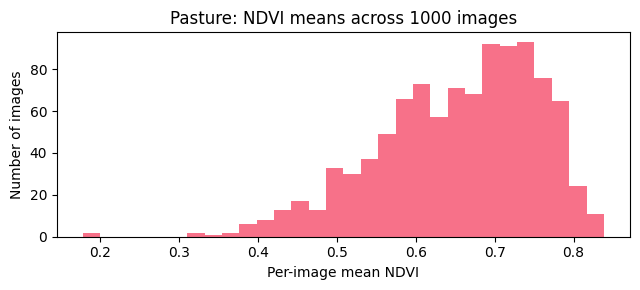


🔎 Takeaways:
- Highest reflectance bands: B13(B8A-NIRNarrow), B07(B07-RedEdge3), B08(B08-NIR), B06(B06-RedEdge2), B11(B11-SWIR1)
- Lowest reflectance (often atmospheric/less useful): B10(B10-Cirrus), B04(B04-Red), B12(B12-SWIR2)
✅ Step 5 done.


In [7]:
# ====== STEP 5: Large-Scale Pasture Spectral Statistics ======
import time
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
import pandas as pd

# Suppress non-critical rasterio warnings
warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)

print(f"📊 Starting Large-Scale {CLASS_NAME} Spectral Analysis...")
print("=" * 55)

pasture_dir = DATA_DIR / CLASS_NAME
files = sorted(pasture_dir.glob("*.tif"))
assert len(files) > 0, f"No .tif files found in {pasture_dir}"

# --- Configure analysis parameters ---
MAX_SAMPLES = min(1000, len(files))
N_THREADS   = 4
selected_files = files[:MAX_SAMPLES]
print(f"📁 Analyzing {len(selected_files):,} {CLASS_NAME} images out of {len(files):,} available")
print(f"⚡ Using {N_THREADS} threads for parallel processing")

# --- Get metadata from a single file to use for all images ---
with rasterio.open(selected_files[0]) as src0:
    band_count = src0.count
    sample_height, sample_width = src0.height, src0.width
print(f"📏 Image dimensions: {sample_height} × {sample_width} pixels")
print(f"📊 Spectral bands: {band_count}")

# --- Detailed Sentinel-2 band information ---
SENTINEL2_DETAILED = {
     1: {'name': 'B01-Coastal',    'wavelength': '443nm',  'resolution': 60},
     2: {'name': 'B02-Blue',       'wavelength': '490nm',  'resolution': 10},
     3: {'name': 'B03-Green',      'wavelength': '560nm',  'resolution': 10},
     4: {'name': 'B04-Red',        'wavelength': '665nm',  'resolution': 10},
     5: {'name': 'B05-RedEdge1',   'wavelength': '705nm',  'resolution': 20},
     6: {'name': 'B06-RedEdge2',   'wavelength': '740nm',  'resolution': 20},
     7: {'name': 'B07-RedEdge3',   'wavelength': '783nm',  'resolution': 20},
     8: {'name': 'B08-NIR',        'wavelength': '842nm',  'resolution': 10},
     9: {'name': 'B09-WaterVapor', 'wavelength': '945nm',  'resolution': 60},
    10: {'name': 'B10-Cirrus',     'wavelength': '1375nm', 'resolution': 60},
    11: {'name': 'B11-SWIR1',      'wavelength': '1610nm', 'resolution': 20},
    12: {'name': 'B12-SWIR2',      'wavelength': '2190nm', 'resolution': 20},
    13: {'name': 'B8A-NIRNarrow',  'wavelength': '865nm',  'resolution': 20},
}

# --- Function to compute statistics for a single band array ---
def per_band_stats(arr: np.ndarray):
    x = arr.astype(np.float32)
    valid = x[x > 0]
    if valid.size == 0:
        return {'mean': np.nan, 'std': np.nan, 'min': np.nan, 'max': np.nan,
                'median': np.nan, 'p05': np.nan, 'p95': np.nan, 'nonzero_pct': 0.0}
    return {
        'mean': float(valid.mean()), 'std': float(valid.std()), 'min': float(valid.min()), 'max': float(valid.max()),
        'median': float(np.median(valid)), 'p05': float(np.percentile(valid, 5)), 'p95': float(np.percentile(valid, 95)),
        'nonzero_pct': float(100 * valid.size / x.size)
    }

# --- Worker function to process a single image in parallel ---
def process_single_image(filepath):
    try:
        with rasterio.open(filepath) as src:
            if src.count != band_count:
                return None, f"Band mismatch in {filepath.name}: expected {band_count}, got {src.count}"
            stats = {'filename': filepath.name}
            cache = {}
            for b in range(1, band_count+1):
                arr = src.read(b)
                cache[b] = arr
                s = per_band_stats(arr)
                for k, v in s.items():
                    stats[f'band_{b}_{k}'] = v
            red = cache[4].astype(np.float32); nir = cache[8].astype(np.float32)
            ndvi = (nir - red) / (nir + red + 1e-6); ndvi = np.clip(ndvi, -1, 1)
            stats['ndvi_mean'] = float(np.nanmean(ndvi))
            return stats, None
    except Exception as e:
        return None, f"Error {filepath.name}: {e}"

# --- Main processing loop using a ThreadPoolExecutor for speed ---
results, errors = [], []
t0 = time.time()
with ThreadPoolExecutor(max_workers=N_THREADS) as ex:
    futs = {ex.submit(process_single_image, fp): fp for fp in selected_files}
    for i, fut in enumerate(as_completed(futs), 1):
        res, err = fut.result()
        if res is not None: results.append(res)
        if err is not None: errors.append(err)
        if i % 100 == 0 or i == len(selected_files):
            print(f"  → Processed {i}/{len(selected_files)} images...")
print(f"⏱️ Finished in {time.time()-t0:.1f}s | Success: {len(results)} | Errors: {len(errors)}")
if errors:
    print("\n".join(errors[:3]))

df = pd.DataFrame(results); assert len(df)>0, "No images processed—cannot summarize."
display(df.head())

# --- Create a summary table of band statistics across all images ---
summary_rows = []
for b in range(1, band_count+1):
    m  = df[f'band_{b}_mean'].to_numpy(dtype=float)
    sd = df[f'band_{b}_std'].to_numpy(dtype=float)
    p5 = df[f'band_{b}_p05'].to_numpy(dtype=float)
    p95= df[f'band_{b}_p95'].to_numpy(dtype=float)
    nz = df[f'band_{b}_nonzero_pct'].to_numpy(dtype=float)
    summary_rows.append({
        'band': f'B{b:02d}', 'name': SENTINEL2_DETAILED.get(b, {}).get('name', f'B{b:02d}'),
        'wavelength': SENTINEL2_DETAILED.get(b, {}).get('wavelength', 'N/A'),
        'resolution': SENTINEL2_DETAILED.get(b, {}).get('resolution', 'N/A'),
        'mean_of_means': float(np.nanmean(m)), 'std_of_means': float(np.nanstd(m)),
        'p05_mean': float(np.nanpercentile(m, 5)), 'p95_mean': float(np.nanpercentile(m, 95)),
        'mean_of_stds': float(np.nanmean(sd)), 'mean_p05': float(np.nanmean(p5)), 'mean_p95': float(np.nanmean(p95)),
        'avg_nonzero_pct': float(np.nanmean(nz)), 'n_images': int(len(df))
    })
summary = pd.DataFrame(summary_rows); display(summary)

# --- Visualize mean reflectance and distribution ---
plt.figure(figsize=(9, 3.2))
plt.bar(summary['band'], summary['mean_of_means'])
plt.xticks(rotation=45); plt.ylabel('Mean reflectance (per-image mean)')
plt.title(f"{CLASS_NAME}: Mean reflectance by band (n={len(df)})")
plt.tight_layout(); plt.show()

data_for_box = [df[f'band_{b}_mean'].to_numpy(dtype=float) for b in range(1, band_count+1)]
plt.figure(figsize=(10, 3.6)); plt.boxplot(data_for_box, labels=[f'B{b:02d}' for b in range(1, band_count+1)], showfliers=False)
plt.xticks(rotation=45); plt.ylabel('Per-image mean reflectance')
plt.title(f"{CLASS_NAME}: Distribution of per-image means by band")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6.5, 3)); plt.hist(df['ndvi_mean'].to_numpy(dtype=float), bins=30)
plt.xlabel('Per-image mean NDVI'); plt.ylabel('Number of images')
plt.title(f"{CLASS_NAME}: NDVI means across {len(df)} images")
plt.tight_layout(); plt.show()

# --- Print key takeaways from the analysis ---
top_bands = summary.sort_values('mean_of_means', ascending=False).head(5)[['band','name']]
low_bands = summary.sort_values('mean_of_means', ascending=True).head(3)[['band','name']]
print("\n🔎 Takeaways:")
print("- Highest reflectance bands:", ", ".join([f"{b}({n})" for b,n in top_bands.to_numpy()]))
print("- Lowest reflectance (often atmospheric/less useful):", ", ".join([f"{b}({n})" for b,n in low_bands.to_numpy()]))
print("✅ Step 5 done.")
